# Training a classifier

## What about data?

일반적으로 이미지, 텍스트, 오디오 또는 비디오 데이터를 다룰 때, 우리는 데이터를 numpy array로 load하는 일반적인 python package들을 사용할 수 있다. 그런 다음 numpy array를 torch의 tensor로 변환할 수 있다. 

이미지의 경우 Pillow나 OpenCV와 같은 package가 유용하다. 

오디오의 경우에는 scipy나 librosa가 유용하다. 

텍스트의 경우 python 또는 Cython, NLTK, SpaCy 등이 유용하다. 

특히 vision analysis를 위해 **torchvision**에는 **torchvision.dataset**, **torch.utils.data.DataLoader**와 같은 이미지용 데이터 처리 package가 있다. 

여기에서는 CIFAR10 dataset을 이용하여 연습한다. 

하나의 이미지는 **3x32x32** 이미지이다. 

## Image classifier 연습

다음의 단계로 진행:
1. CIFAR10 training and test dataset을 torchvision을 이용해서 load하고 normalizing 한다. 
2. Convolutional Neural Network를 정의한다. 
3. loss function을 정의한다. 
4. Training을 시행한다. 
5. Test dataset에서 network를 시험한다. 

## 1. Loading and normalizing CIFAR10

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms # for data normalization 

**torchvision** dataset의 출력은 [0, 1] 범위의 PILImage이다. 따라서 torchvision에서 load한 dataset은 [-1, 1] 범위에서 normalize한 tensor로 전환해주어야 한다. 

In [0]:
# define how to normalize the image dataset
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [19]:
trainset = torchvision.datasets.CIFAR10(root='./tmp', train=True, 
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [20]:
testset = torchvision.datasets.CIFAR10(root='./tmp', train=False, 
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, 
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


In [0]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


### Visualize some of the training images

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# image를 보여주는 함수
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [0]:
# get some random images from training dataset
dataiter = iter(trainloader)
images, labels = dataiter.next()

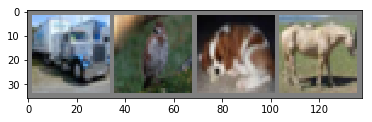

truck  bird   dog horse


In [25]:
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

##2. Define CNN

In [0]:
import torch.nn as nn 
import torch.nn.functional as F

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5) # input channel, output channel, kernel
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
net = Net()

In [32]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


##3. Define a loss function and optimizer 

Use loss function as **nn.CrossEntropyLoss()**

and optimizer as **SGD**

In [0]:
# define loss function 
criterion = nn.CrossEntropyLoss()

# define optimizer 
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

##4. Train the network

In [34]:
print('Start Training')

for epoch in range(2): # loop over the dataset multiple times
  
  running_loss = 0.0
  
  for i, data in enumerate(trainloader, 0):
    
    # get inputs: data is a list of [inputs, labels]
    inputs, labels = data
    
    # initialize the parameter gradients 
    optimizer.zero_grad()
    
    # forward => backward => optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    # print statistics 
    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' % 
            (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0
      
print('Finished Training')

Start Training
[1,  2000] loss: 2.185
[1,  4000] loss: 1.832
[1,  6000] loss: 1.652
[1,  8000] loss: 1.564
[1, 10000] loss: 1.488
[1, 12000] loss: 1.443
[2,  2000] loss: 1.369
[2,  4000] loss: 1.374
[2,  6000] loss: 1.345
[2,  8000] loss: 1.300
[2, 10000] loss: 1.289
[2, 12000] loss: 1.267
Finished Training


##5. Test the network with test dataset

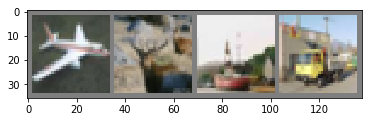

GroundTruth:  plane  deer  ship truck


In [35]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
# test the images
outputs = net(images)

In [37]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    car  frog  ship  ship


In [38]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [39]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 54 %
Accuracy of   car : 80 %
Accuracy of  bird : 46 %
Accuracy of   cat : 33 %
Accuracy of  deer : 46 %
Accuracy of   dog : 34 %
Accuracy of  frog : 67 %
Accuracy of horse : 68 %
Accuracy of  ship : 78 %
Accuracy of truck : 50 %


##6. Training on GPU

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

In [0]:
net.to(device)

In [0]:
inputs, labels = data[0].to(device), data[1].to(device)